# Telecom Plan Analysis

In this notebook, we will review a few datasets compiled for customers of a telecom operator. This company offers two prepaid plans: Surf and Ultimate. We will analyze the data here to determine which of the two is more profitable. This analysis can help the company decide which plan is worth advertising more. 

The datasets will contain information on 500 clients, as well as the fine details on each plan. 

Let's start by loading and reviewing our data.

In [1]:
import pandas as pd
import numpy as np

user_data = pd.read_csv('/datasets/megaline_users.csv')
call_data = pd.read_csv('/datasets/megaline_calls.csv')
internet_data = pd.read_csv('/datasets/megaline_internet.csv')
message_data = pd.read_csv('/datasets/megaline_messages.csv')
plan_data = pd.read_csv('/datasets/megaline_plans.csv')

In [2]:
display(user_data.describe())
user_data.head()

,user_id,age
count,500.000000,500.000000
mean,1249.500000,45.486000
std,144.481833,16.972269
min,1000.000000,18.000000
25%,1124.750000,30.000000
50%,1249.500000,46.000000
75%,1374.250000,61.000000
max,1499.000000,75.000000


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In the first dataset - the user data - we have our user_id (an identifier we will see in the other tables), the user's first and last name, age, city of residence, plan start date, plan type, and whether they canceled their plan (churn_date specifies when the plan ended). If the churn_date is null (or NaN), then they are still a customer. We will address this when we start cleaning our tables, but for now let's continue. 

In [3]:
display(call_data.describe())
call_data.head()

,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


This table is fairly straightforward. We have the same user_id, as well as an id column. The id column specifies a unique identifier for the call. We probably won't need this one for our analysis but we'll save that for later as well. Otherwise we have the call date and a duration in decimal minutes. The telecom company counts and charges calls by the minute and rounds up - so we will need to fix this later in our data wrangling.

In [4]:
display(internet_data.describe())
internet_data.head()

,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Just like the last one, we have two id columns, a session date, and the MB of data used on a web session. The telecom company does not round the MB used per session, but rather the total for the month. So when we start to analyze these plans for profitability, we will need to keep that in mind. The total MB used by a user per month will need to be rounded up to the nearest GB. 

In [5]:
display(message_data.describe())
message_data.head()

,user_id
count,76051.000000
mean,1245.972768
std,139.843635
min,1000.000000
25%,1123.000000
50%,1251.000000
75%,1362.000000
max,1497.000000


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Nothing we haven't seen before here. Two id columns for the text message, and a timestamp.

In [6]:
plan_data.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


And lastly, above we can see the information about our two plans. We can see the total messages, data, and call minutes included, as well as the price of the plan, and how much you would be charged for each minute, message, or GB over plan.

Now that we have a good idea of what we are dealing with, let's go back to each one and fix the data types, check for nulls and duplicates, and create some more helpful features.

## Data Wrangling

### User Data

First we'll take a look at our user data. It's the biggest and will probably need the most help.

In [7]:
user_data.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [8]:
user_data.isna().sum()

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

That's what we like to see! No missing values with the exception of the churn_date - but we expected those and know what they mean already. The "null" churn_date simply means that the user is an active customer. Let's leave it for now so that we can convert the column to date-time format later.

Next let's look at the data types

In [9]:
user_data.dtypes

user_id        int64
first_name    object
last_name     object
age            int64
city          object
reg_date      object
plan          object
churn_date    object
dtype: object

The types are clear, but I think we need to take a closer look at a few of the object columns to make sure. I want to check the city as it could have some messy strings. I also want to adjust the reg_date to date-time format. We can do this with the churn_date as well. Lastly, I want to look at the plans and make sure that we only have two: Surf or Ultimate.

In [10]:
sorted(user_data['city'].unique())

['Albany-Schenectady-Troy, NY MSA',
 'Albuquerque, NM MSA',
 'Atlanta-Sandy Springs-Roswell, GA MSA',
 'Austin-Round Rock-Georgetown, TX MSA',
 'Bakersfield, CA MSA',
 'Baltimore-Columbia-Towson, MD MSA',
 'Baton Rouge, LA MSA',
 'Birmingham-Hoover, AL MSA',
 'Boston-Cambridge-Newton, MA-NH MSA',
 'Bridgeport-Stamford-Norwalk, CT MSA',
 'Buffalo-Cheektowaga, NY MSA',
 'Cape Coral-Fort Myers, FL MSA',
 'Charleston-North Charleston, SC MSA',
 'Charlotte-Concord-Gastonia, NC-SC MSA',
 'Chicago-Naperville-Elgin, IL-IN-WI MSA',
 'Cincinnati, OH-KY-IN MSA',
 'Cleveland-Elyria, OH MSA',
 'Colorado Springs, CO MSA',
 'Columbia, SC MSA',
 'Columbus, OH MSA',
 'Dallas-Fort Worth-Arlington, TX MSA',
 'Dayton-Kettering, OH MSA',
 'Denver-Aurora-Lakewood, CO MSA',
 'Detroit-Warren-Dearborn, MI MSA',
 'El Paso, TX MSA',
 'Fresno, CA MSA',
 'Grand Rapids-Kentwood, MI MSA',
 'Greensboro-High Point, NC MSA',
 'Houston-The Woodlands-Sugar Land, TX MSA',
 'Indianapolis-Carmel-Anderson, IN MSA',
 'Jackson

Everything appears to check out here! Research has shown me that MSA is short for "Metropolitan Statistical Area" so I'm happy with the look of everything. Let's look at our plans next.

In [11]:
user_data['plan'].unique()

array(['ultimate', 'surf'], dtype=object)

Excellent. No issues here. Let's work on the reg_date and churn_date now.

In [12]:
user_data['reg_date'] = pd.to_datetime(user_data['reg_date'], format='%Y-%m-%d')
user_data['churn_date'] = pd.to_datetime(user_data['churn_date'], format='%Y-%m-%d')

In [13]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null datetime64[ns]
plan          500 non-null object
churn_date    34 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Great - we are almost done with this one. Last thing we need to check for is duplicate rows.

In [14]:
user_data.duplicated().sum()

0

Perfect - ok, we have gotten this dataset in shape. Let's move on to the next one.

### Call Data

In [15]:
call_data.isna().sum()

id           0
user_id      0
call_date    0
duration     0
dtype: int64

In [16]:
call_data.duplicated().sum()

0

Ok great, no big issues to take care of. The only two things we need to do here are to change the call_date to date-time format and round the call duration up to the nearest minute, since this is how the telecom company charges users.

In [17]:
call_data['call_date'] = pd.to_datetime(call_data['call_date'], format='%Y-%m-%d')
call_data['duration'] = call_data['duration'].apply(np.ceil).astype('int')

# verify
display(call_data.dtypes)
call_data.head()

id                   object
user_id               int64
call_date    datetime64[ns]
duration              int64
dtype: object

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9
1,1000_145,1000,2018-12-27,14
2,1000_247,1000,2018-12-27,15
3,1000_309,1000,2018-12-28,6
4,1000_380,1000,2018-12-30,5


I think at this point we've done all we can for this dataset. The datatypes appear correct, and there are no nulls or duplicates we need to address. Let's move on.

### Internet Data

In [18]:
internet_data.isna().sum()

id              0
user_id         0
session_date    0
mb_used         0
dtype: int64

In [19]:
internet_data.duplicated().sum()

0

Ok, so like the above dataset there is nothing critical we need to address here in terms of duplicates or nulls. But we do need to fix the session date and convert it to date-time format. This will be especially critical here when we need to calculate the total amount of data used, as it is charged by the GB over the alloted amount. We will need to round up the sum total for each month to determine what to charge (if anything).

In [20]:
internet_data['session_date'] = pd.to_datetime(internet_data['session_date'], format='%Y-%m-%d')

# verify
internet_data.dtypes

id                      object
user_id                  int64
session_date    datetime64[ns]
mb_used                float64
dtype: object

Alright, I think that's all we can do for now. We'll come back to this dataset after we examine the last one to group the MB usage per user per month.

### Message Data

In [21]:
message_data.isna().sum()

id              0
user_id         0
message_date    0
dtype: int64

In [22]:
message_data.duplicated().sum()

0

Great - overall we have some fairly clean datasets. There have been no problematic nulls or duplicates to deal with! However, we need to do the same dtype conversion here as we have above to make summing the messages by month easier.

In [23]:
message_data['message_date'] = pd.to_datetime(message_data['message_date'], format='%Y-%m-%d')

# verify
message_data.dtypes

id                      object
user_id                  int64
message_date    datetime64[ns]
dtype: object

Everything appears fine here as well. Now that all of our datasets have been examined and fixed, let's start to pull some base values from them. 

In the next section, we will use groupby and pivot tables to determine:
* The number of calls made and minutes used per month
* The number of text messages sent per month
* The volume of data per month
* The monthly revenue from each user (any revenue gained from overage charges)

## Data Analysis

First, let's search to find the total number of calls made and minutes used per month for each user. To do this, we should examine the call_data df to find these values and group them by user. Then we can do the same for the number of text messages and volume of data in their respective dfs. After we have these three sets of values, we can join those users to the user_data df to figure out which plan they have. This last step will allow us to determine the monthly revenue gained from any overages in messages, calls, or data.

In [24]:
# We'll need a new column first
call_data['month'] = pd.DatetimeIndex(call_data['call_date']).month

# Then we can group and see the results
calls_made = pd.pivot_table(
    call_data,
    values='duration',
    index=['user_id', 'month'],
    aggfunc=['sum', 'count']
)
calls_made.head(10)

sum    count
              duration duration
user_id month                  
1000    12         124       16
1001    8          182       27
        9          315       49
        10         393       65
        11         426       64
        12         412       56
1002    10          59       11
        11         386       55
        12         384       47
1003    12        1104      149

First table down - now we need to set up a similar table for the messages and internet data. 

In [25]:
message_data['month'] = pd.DatetimeIndex(message_data['message_date']).month

messages_sent = pd.pivot_table(
    message_data,
    values='id',
    index=['user_id', 'month'],
    aggfunc='count'
)
messages_sent.head(10)

id
user_id month    
1000    12     11
1001    8      30
        9      44
        10     53
        11     36
        12     44
1002    10     15
        11     32
        12     41
1003    12     50

In [26]:
internet_data['month'] = pd.DatetimeIndex(internet_data['session_date']).month

data_used = pd.pivot_table(
    internet_data,
    values='mb_used',
    index=['user_id', 'month'],
    aggfunc='sum'
)
data_used.head(10)

mb_used
user_id month          
1000    12      1901.47
1001    8       6919.15
        9      13314.82
        10     22330.49
        11     18504.30
        12     19369.18
1002    10      6552.01
        11     19345.08
        12     14396.24
1003    12     27044.14

For the internet data, we will also need to create one more column containing the total GB used per month, rounded up. This is how the telecom company charges for overage data, so we will need this metric to determine any additional charges to the user.

In [27]:
data_used['gb_rounded'] = (data_used['mb_used']/1024).apply(np.ceil)

Now that we have the full usage of each user per month pulled out into these pivot tables, we can assemble them into one dataset. This df will help us determine how much revenue the telecom company earns for any overage charges, and ultimately to determine which of the two plans generates more profit.

In [28]:
dfs = [calls_made, messages_sent, data_used]
usage_data = pd.concat(dfs, axis=1)
    
usage_data.head(10)

(sum, duration)  (count, duration)    id   mb_used  gb_rounded
user_id month                                                                
1000    12               124.0               16.0  11.0   1901.47         2.0
1001    8                182.0               27.0  30.0   6919.15         7.0
        9                315.0               49.0  44.0  13314.82        14.0
        10               393.0               65.0  53.0  22330.49        22.0
        11               426.0               64.0  36.0  18504.30        19.0
        12               412.0               56.0  44.0  19369.18        19.0
1002    10                59.0               11.0  15.0   6552.01         7.0
        11               386.0               55.0  32.0  19345.08        19.0
        12               384.0               47.0  41.0  14396.24        15.0
1003    12              1104.0              149.0  50.0  27044.14        27.0

In [29]:
# Rename columns to make it easier to use
usage_data = usage_data.rename(columns={
    ('sum', 'duration'):'minutes_total',
    ('count', 'duration'):'call_number_total',
    'id':'text_total',
})

In [30]:
usage_data.head(10)

minutes_total  call_number_total  text_total   mb_used  \
user_id month                                                           
1000    12             124.0               16.0        11.0   1901.47   
1001    8              182.0               27.0        30.0   6919.15   
        9              315.0               49.0        44.0  13314.82   
        10             393.0               65.0        53.0  22330.49   
        11             426.0               64.0        36.0  18504.30   
        12             412.0               56.0        44.0  19369.18   
1002    10              59.0               11.0        15.0   6552.01   
        11             386.0               55.0        32.0  19345.08   
        12             384.0               47.0        41.0  14396.24   
1003    12            1104.0              149.0        50.0  27044.14   

               gb_rounded  
user_id month              
1000    12            2.0  
1001    8             7.0  
        9            14.0  
        10           22.0  
        11           19.0  
        12           19.0  
1002    10            7.0  
        11           19.0  
        12           15.0  
1003    12           27.0

We will need to merge the user plan type into this dataframe in order to analyze how much revenue we earn. We have this information linked to the user_id in our first dataset (user_data). Let's pull these columns along with the city (for later) out into their own df and then merge this into the usage_data to get it all in one place.

In [31]:
user_plans = user_data[['user_id', 'city', 'plan']]

In [32]:
usage_data_plans = pd.merge(usage_data, user_plans, left_index=True, on='user_id', how='left')

In [33]:
usage_data_plans.head()

,user_id,minutes_total,call_number_total,text_total,mb_used,gb_rounded,city,plan
0,1000,124.0,16.0,11.0,1901.47,2.0,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate
1,1001,182.0,27.0,30.0,6919.15,7.0,"Seattle-Tacoma-Bellevue, WA MSA",surf
1,1001,315.0,49.0,44.0,13314.82,14.0,"Seattle-Tacoma-Bellevue, WA MSA",surf
1,1001,393.0,65.0,53.0,22330.49,22.0,"Seattle-Tacoma-Bellevue, WA MSA",surf
1,1001,426.0,64.0,36.0,18504.30,19.0,"Seattle-Tacoma-Bellevue, WA MSA",surf


In [34]:
display(usage_data.shape)
display(user_plans.shape)
usage_data_plans.shape

(2293, 5)

(500, 3)

(2293, 8)

Checking on the shapes of each df before and after the merge, we can see that three columns were added and the number of rows before and after are the same (for the left df). Now that we have everything grouped together, it's time to calculate how much revenue we earn from each customer.

In [35]:
def calculate_revenue(row):
    """
    Calculates the total revenue earned from a customer depending on the plan they have, on top of the monthly cost of the plan.
    """
    if row['plan'] == 'surf':
        surf_mins_money = 0
        surf_text_money = 0
        surf_data_money = 0
        surf_mins_used = row['minutes_total'] - 500
        if surf_mins_used > 0:
            surf_mins_money = surf_mins_used*0.03
        surf_text_used = row['text_total'] - 50
        if surf_text_used > 0:
            surf_text_money = surf_text_used*0.03
        surf_data_used = row['gb_rounded'] - 15
        if surf_data_used > 0:
            surf_data_money = surf_data_used*10
        surf_revenue = surf_mins_money + surf_text_money + surf_data_money + 20
        return surf_revenue
    else:
        ult_mins_money = 0
        ult_text_money = 0
        ult_data_money = 0
        ult_mins_used = row['minutes_total'] - 3000
        if ult_mins_used > 0:
            ult_mins_money = ult_mins_used*0.01
        ult_text_used = row['text_total'] - 1000
        if ult_text_used > 0:
            ult_text_money = ult_text_used*0.01
        ult_data_used = row['gb_rounded'] - 30
        if ult_data_used > 0:
            ult_data_money = ult_data_used*7
        ult_revenue = ult_mins_money + ult_text_money + ult_data_money + 70
        return ult_revenue

In [36]:
usage_data_plans['revenue'] = usage_data_plans.apply(calculate_revenue, axis=1)

In [37]:
# Verify
usage_data_plans.head(10)

,user_id,minutes_total,call_number_total,text_total,mb_used,gb_rounded,city,plan,revenue
0,1000,124.0,16.0,11.0,1901.47,2.0,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,70.00
1,1001,182.0,27.0,30.0,6919.15,7.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,20.00
1,1001,315.0,49.0,44.0,13314.82,14.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,20.00
1,1001,393.0,65.0,53.0,22330.49,22.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,90.09
1,1001,426.0,64.0,36.0,18504.30,19.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,60.00
1,1001,412.0,56.0,44.0,19369.18,19.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,60.00
2,1002,59.0,11.0,15.0,6552.01,7.0,"Las Vegas-Henderson-Paradise, NV MSA",surf,20.00
2,1002,386.0,55.0,32.0,19345.08,19.0,"Las Vegas-Henderson-Paradise, NV MSA",surf,60.00
2,1002,384.0,47.0,41.0,14396.24,15.0,"Las Vegas-Henderson-Paradise, NV MSA",surf,20.00
3,1003,1104.0,149.0,50.0,27044.14,27.0,"Tulsa, OK MSA",surf,158.12


At this point we have completed all of the preparations needed to properly analyze which plan is more profitable for the telecom operator. We were able to clean the dataframes we started with and group the data we needed from each one. Then we merged the customer usage data into one dataframe and built a function to calculate the revenue earned each month. After applying this function to the customer usage data, we are left with the above. The next step is to take this dataframe and search for trends. We can make use of some data visualization to help in this effort. 

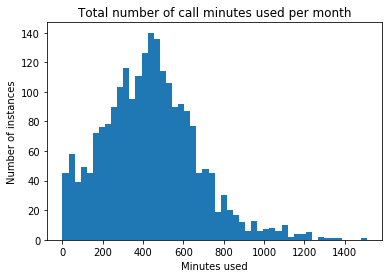

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(x=usage_data_plans['minutes_total'], bins=50)
plt.xlabel('Minutes used')
plt.ylabel('Number of instances')
plt.title('Total number of call minutes used per month');

Looking at the above, we can see a peak at about 400 minutes with a long tail to the right. There appear to be some outliers in place - certainly on the high end. Since the number of instances appears to decrease after 1200 minutes, we will cut off the data there and consider anything higher then that as an outlier. There are also a lot of 0 values. This is certainly possible given what we are measuring. I'm sure there are people that exclusively communicate over text or online. These users would have 0 call minutes used by the end of the month. Given the nature of communication now, this is not unexpected.

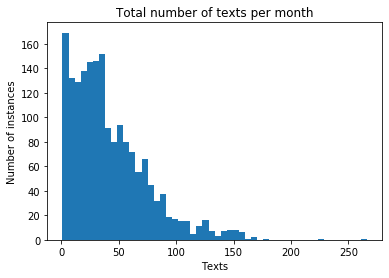

In [39]:
plt.hist(x=usage_data_plans['text_total'], bins=50)
plt.xlabel('Texts')
plt.ylabel('Number of instances')
plt.title('Total number of texts per month');

Most of the data here appears to be focused under 100 texts per month. There are a significant numebr of instances up to 150 texts, and after that we are left with the highest outliers. Anything after 150 should be safe to remove. There are a significant number of users that send 0 texts per month. This is entirely possible, especially for older users that may not be used to texting as a form of communication. 

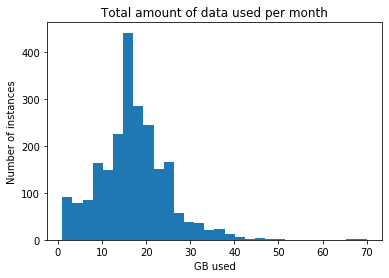

In [40]:
plt.hist(x=usage_data_plans['gb_rounded'], bins=30)
plt.xlabel('GB used')
plt.ylabel('Number of instances')
plt.title('Total amount of data used per month');

The peak here is around 15 GB of data used in one month, with most of the data focused between 0 and 40 GB. We can remove anything after 40 GB as an outlier, since there are only a few instances of data usage higher than that. There are a significant number low data (0-1 GB) users, which is possible if the user exclusively uses their phone when attached to a Wi-Fi network. If the user is using Wi-Fi, they can avoid using cellular data.

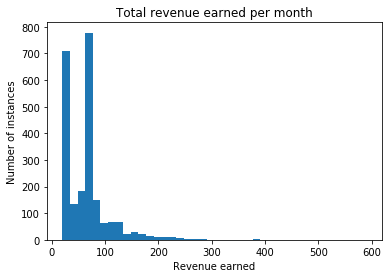

In [41]:
plt.hist(x=usage_data_plans['revenue'], bins=40)
plt.xlabel('Revenue earned')
plt.ylabel('Number of instances')
plt.title('Total revenue earned per month');

There are two very significant peaks here - one at 20 and another at 70 per month, which is exactly how much the Surf and Ultimate plans cost, respectively. After these peaks, the revenue earned trails to about 200, with a few more instances afterwards. Removing the revenue earned after 200 should take care of these extreme outliers and will allow us to analyze the dataframe properly.

In [42]:
display(np.var(usage_data_plans))
usage_data_plans.describe()

user_id              2.045493e+04
minutes_total        5.378734e+04
call_number_total    1.008941e+03
text_total           1.096521e+03
mb_used              6.190631e+07
gb_rounded           5.916677e+01
revenue              2.172937e+03
dtype: float64

,user_id,minutes_total,call_number_total,text_total,mb_used,gb_rounded,revenue
count,2293.000000,2258.000000,2258.000000,1806.000000,2277.000000,2277.000000,2293.000000
mean,1246.075883,435.937555,60.998671,42.110188,16882.197501,16.989021,64.351147
std,143.051927,231.972343,31.770869,33.122931,7869.784848,7.693683,46.624945
min,1000.000000,0.000000,1.000000,1.000000,92.310000,1.000000,20.000000
25%,1122.000000,275.000000,39.000000,17.000000,12347.720000,13.000000,23.480000
50%,1245.000000,429.000000,60.000000,34.000000,16873.740000,17.000000,70.000000
75%,1368.000000,574.750000,80.000000,59.000000,21041.520000,21.000000,70.000000
max,1499.000000,1510.000000,205.000000,266.000000,70931.590000,70.000000,590.370000


From the above, we can start to get a rough idea of how the plans are used, and what our extreme values are. Customers on average appear to talk for approx. 436 minutes per month, with a stdev of 232 minutes! The minutes used appear to be fairly spread out around the mean, with a slight skew to the right as the mean sits higher than the median (429 mins). 75% of the data is below 575 minutes, with a max value of 1510 mins. This tells us that there is a large spread on the upper end of the minutes used, which likely causes this "skew" to the right. There are also some customers who make no calls at all. <br><br>
Looking at the text column, we see that the mean is 42 texts per month, with a median of 34, and a stdev of 33. Again, we have a skew to the right and data that appears to be fairly spread out around the median/mean. 75% of the data is at or below 59 texts per month, and the maximum sent is 266. This noticeably large max value is causing the right skew, as the 25, 50, and 75% values show most of the data at least 200+ texts below that maximum. <br><br>
Moving on to the data used, we have a mean and median of 17 GB, and a stdev of 7.7 GB. There is no real skew to the data, though it does appear to again be spread around the median/mean with a relatively large stdev. The max GB used is 70, which is substantially higher than the 75% mark of 21 GB. Perhaps we have one or two users who watch TV or movies offline, or play games during their communte on public transit? Either way, we again have some outliers on the far end of the spectrum. <br><br>
Lastly we will take a look at the revenue. We have a mean of 64.3 and median of 70 earned per month from our customers, with a stdev of 46.6. There's a skew to the left this time, with many of our customers making us no additional revenue off of the base monthly cost of each plan (20 for surf and 70 for ultimate). Notice that the min is exactly 20, and at least 25% of our customers make the operator anywhere from 20 to 23.48 per month. Since the median is exactly 70, it seems as if at least half of the customer base in our dataframe is on the ultimate plan, and because 75% of the customer base is also at 70 in revenue earned, those customers are not making the operator anything on top of the plan cost. The histogram verifies this, as we see two noticable spikes, one likely at 20 and the other at 70. We have a relatively huge maximum value of 590.37 earned in one month from some lucky/unlucky customer. Overall, I think we can attribute the large stdev here to the fact that most of the customers are not being charged much after their alloted data, minutes, and texts, making most of the customers "revenue" equal to the cost of the plan (20 or 70). This roughly 50 gap is noticeably close to the stdev of 46.6. I would be willing to bet that if our dataframe included more, the stdev would trend closer to 50. 

Let's remove our outliers now and take a look at the difference in the spread of our distributions.

In [43]:
outlier_data = usage_data_plans.query(
    'minutes_total > 1200 | text_total > 150 | gb_rounded > 40 | revenue > 200'
)

In [44]:
usage_data_plans = usage_data_plans.drop(outlier_data.index, axis=0)

Now that we've removed our outliers, let's take a look at our distributions again.

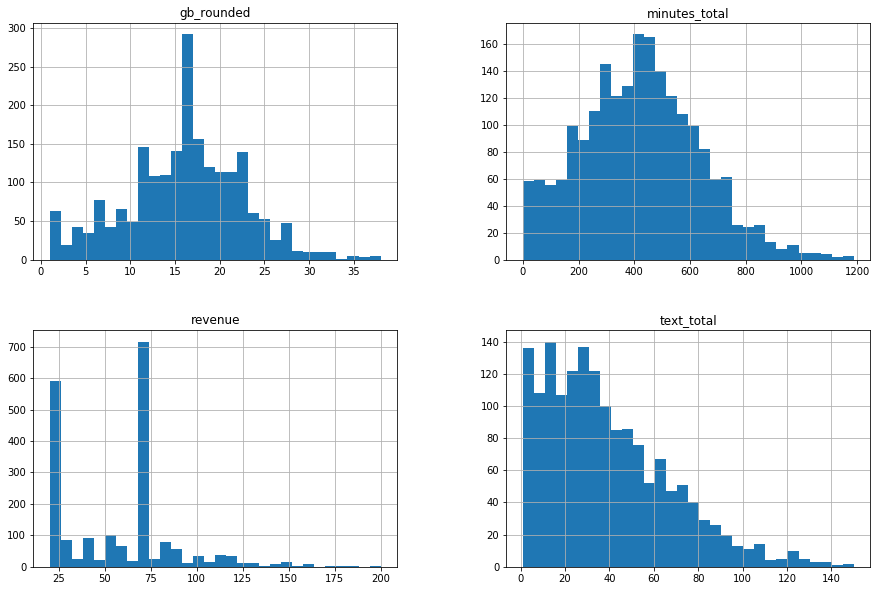

In [45]:
usage_data_plans[['minutes_total', 'text_total', 'gb_rounded', 'revenue']].hist(bins=30, figsize=(15,10));

Excellent, that's much better. Now that we've cleaned and examined the distributions, let's really dig into this and see which plan makes the telecom operator more revenue through hypothesis testing.

## Hypothesis Testing

We will start with our null hypothesis: The average revenue of our Surf and Ultimate plans are the same. Our alternative hypothesis would then be: The average revenue of our Surf and Ultimate plans differs. We will test this by looking at the p-value, set to 0.05 (or 5 percent), and applying a single sample T-test using scipy.

In [46]:
surf_plans = usage_data_plans.groupby('plan')['revenue'].get_group('surf')
ult_plans = usage_data_plans.groupby('plan')['revenue'].get_group('ultimate')

print(surf_plans.mean(), ult_plans.mean())

50.70832382310985 71.04123711340206


In [47]:
import scipy.stats as st

alpha = 0.05
results = st.ttest_ind(surf_plans, ult_plans)

print('pvalue: ', results.pvalue)
print('alpha: ', alpha)
if results.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print('We cannot reject the null hypothesis')

pvalue:  2.0495597186833804e-44
alpha:  0.05
We reject the null hypothesis


The above test resulted in an extremely small pvalue, indicating that we can reject the null hypothesis and accept the alternative hypothesis: the average revenue of the surf and ultimate plans do differ. The above means indicate this to be true as well - the ultimate plan on average produces more revenue than the surf plan (71 vs 50.7). 

Next we will focus on a specific region: the NY-NJ area. Our null hypothesis will be: The average profit from users in the NY-NJ region is not different from that of users elsewhere. The alternative hypothesis would then be: The average profit from users in the NY-NJ region is different from that of users elsewhere.

In [48]:
# First we need to create a way to just look at users in this region
ny_nj_users_bool = usage_data_plans['city'].apply(lambda x: True if 'NY-NJ' in x else False)
ny_nj_users = usage_data_plans[ny_nj_users_bool]['user_id'].values.tolist()

# Then to create the dataframes to test
ny_nj_plans = usage_data_plans[usage_data_plans['user_id'].isin(ny_nj_users)]['revenue']
other_plans = usage_data_plans[~usage_data_plans['user_id'].isin(ny_nj_users)]['revenue']

ny_nj_plans.mean(), other_plans.mean()

(55.53136871508379, 57.71900174114916)

In [49]:
alpha = 0.05
results = st.ttest_ind(ny_nj_plans, other_plans)

print('pvalue: ', results.pvalue)
print('alpha: ', alpha)
if results.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print('We cannot reject the null hypothesis')

pvalue:  0.23677477795676188
alpha:  0.05
We cannot reject the null hypothesis


From the above we see that we cannot reject the null hypothesis: The average profit from users in the NY-NJ region is NOT different from that of users elsewhere. Looking at the means above, we can see that the other regions appear to be slightly more profitable than the NY-NJ users.

# Conclusion

Overall the data came in nicely without a need for much cleaning. We were able to group usages together from the separate dataframes and create one df with all of the important values. From there, we were able to calculate the revenue earned from each user and could then begin to test out our hypotheses. In the testing phase, we were able to conclude that the average revenue differs between the two plans, and that the Ultimate plan on average creates more revenue. We are also able to conclude that users from the NY-NJ region do not generate more revenue from users elsewhere, though the means seem to indicate that there is a slightly higher average from those other users compared to the NY-NJ customers.